 **How to read this notebook**
-
[README](https://github.com/Yuri-Ian/real-estate-pricing-insights) in both Russian and English.

The core analysis is presented in Russian.
For international reviewers, each section is provided in both Russian and English and begins with short guides for quick navigation:

🔷 **Data sidenote** — key takeaways and findings.

🔶 **Code sidenote** — brief explanation of why and how methods were applied.

Placing these notes at the start of each section makes it easier to grasp the logic of the analysis without reading through the full details.

*P.S.*

*This is one of my early works. At the time, my focus was on careful manual analysis, validating each step and documenting findings in detail. Today, I would implement the same workflow more efficiently — with pipelines, automation, and extended visual analytics. Keeping this notebook in its original form allows me to show the trajectory of my growth.*



# Исследование объявлений о продаже квартир / Exploratory Analysis of Apartment Sale Listings

### Экспортируем данные и изучим общую информацию / Load the data and inspect the overall information

🔷 **Section Data sidenote**

Dataset: 23,699 rows × 22 cols. Mixed dtypes: numeric (area/price/rooms), booleans, and strings (locality names, listing dates). Noticeable missingness in several fields → careful handling required. Histograms show typical mid-range apartments with heavy tails/outliers (likely luxury/unusual listings). Next: cleaning (impute/cast), outlier treatment, then deeper EDA.

🔶 **Section Code sidenote**

What: import pandas/matplotlib; load CSV via pd.read_csv(..., sep='\t'); audit schema with .info(); visualize numeric distributions with data.hist(...). (Extras scatter_matrix, ScalarFormatter imported for later use.)

Why: establish structure/dtypes, surface missingness, and quickly spot skew/outliers to guide preprocessing.

Outcome: confirmed dataset shape & mixed types; distributions reveal long tails → proceed with type fixes, imputation, and anomaly handling.

---

In [4]:
# Импортируем необходимые для работы библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib.ticker import ScalarFormatter

In [5]:
#Изучим информацию о дата-фрейме

data = pd.read_csv('/content/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Датасет содержит 23,699 записей и 22 столбца. Типы данных включают числовые (целые и вещественные), булевые и строковые данные. Числовые столбцы в основном связаны с характеристиками недвижимости (площадь, цена, количество комнат), а строковые данные содержат названия населённых пунктов и даты публикации объявлений. В некоторых столбцах присутствуют значительные пропуски, что требует тщательной обработки.

In [6]:
#Первые пять строк датасета

pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


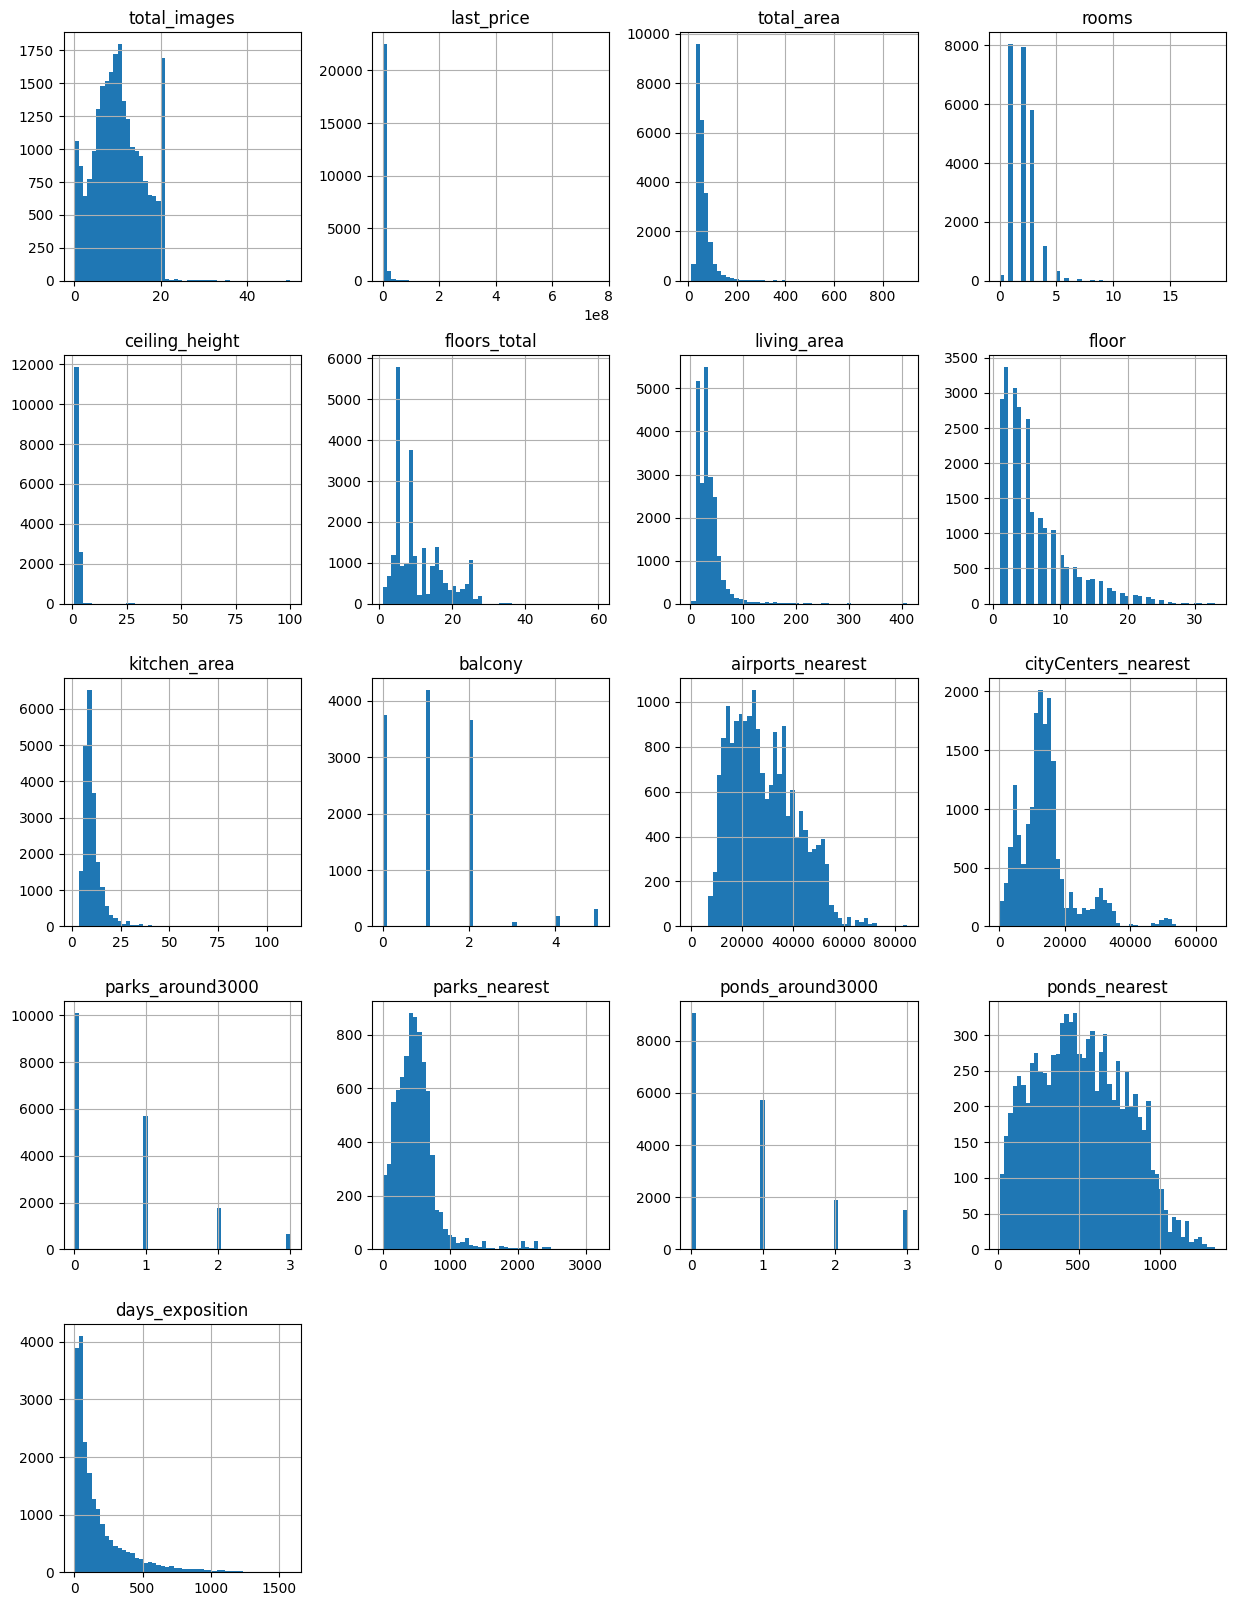

In [7]:
#Построим гистограммы для числовых значений

data.hist(bins=50, figsize=(15, 20))
plt.show()

**Общие выводы:**

Гистограммы показывают типичные характеристики недвижимости в датасете, с основным уклоном на средние квартиры (по площади, количеству комнат и цене). Выбросы могут свидетельствовать об элитной недвижимости или об объектах с необычными характеристиками. Так или иначе, для формирования выводов данные требуют последующей предобработки для избавления от пустых значений, аномалий и прочего, что может исказить результаты исследования.

### Выполните предобработку данных / Perform data preprocessing

🔷 **Section Data sidenote**

We impute only where it’s semantically safe: ceiling_height → median; boolean flags (studio, open_plan, is_apartment) → False; count-like fields (balcony, parks_around3000, ponds_around3000) → 0.

Other missing values remain to avoid speculative fill. Types aligned: first_day_exposition → datetime64; floors_total/balcony → nullable Int64; float columns kept to preserve NaN. Locality names normalized (lowercase, ё→е, phrase cleanup) to remove implicit duplicates and stabilize grouping.

🔶 **Section Code sidenote**

What: audit NaN; create working df; targeted imputations (median/False/0); cast dates/integers; normalize locality_name via case folding and string replacements; re-check dtypes/uniques.

Why: robust fills preserve feature meaning; nullable ints keep NaN without coercing to float; normalized locality names reduce cardinality and join noise.

Outcome: key features are NaN-free and correctly typed; locality labels deduplicated → cleaner EDA/aggregations. (Tip: data_filled = data creates an alias; use data.copy() to avoid side effects.)

---

In [8]:
#Определим, в каких столбцах есть пропуски

data.isna().sum()

,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,9195
floors_total,86
living_area,1903
floor,0
is_apartment,20924


Учитывая специфику данных, постараемся заполнить пропуски таким образом, чтобы максимально точно восстановить пропущенные данные, не вводя в модель ошибочных допущений.

In [9]:
# Для проведения исследования создадим новую переменную  содержащую датафрейм data
data_filled = data

# Заполнение пропусков в 'ceiling_height' медианным значением
data_filled['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

# Пропуски в этих столбцах, вероятно, означают, что квартира не является студией, апартаментами или не имеет свободной планировки
data_filled['studio'] = data['studio'].fillna(False)
data_filled['open_plan'] = data['open_plan'].fillna(False)
data_filled['is_apartment'] = data['is_apartment'].fillna(False)

# Если данные о количестве балконов, парков или водоёмов  в радиусе 3 км отсутствуют, это может означать, что их нет
data_filled['balcony'] = data['balcony'].fillna(0)
data_filled['parks_around3000'] = data['parks_around3000'].fillna(0)
data_filled['ponds_around3000'] = data['ponds_around3000'].fillna(0)


/tmp/ipython-input-2653596290.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_filled['is_apartment'] = data['is_apartment'].fillna(False)


Придерживаясь принципа «заполнять там, где это возможно», мы можем осмысленно заполнить такие столбцы, как:
- число балконов,
- высота потолков
- количество парков и водоёмов,
- параметры квартиры (студия, апартаменты, свободная планировка).

Остальные столбцы с пропусками лучше оставить, так как они могут нести важную информацию или быть слишком сложными для восстановления.

In [73]:
# Проверим, получилось ли избавиться от пустых значений
data_filled.isna().sum()

,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,0
floors_total,86
living_area,1903
floor,0
is_apartment,0


Желаемые пропуски устранены. К возможным причинам появления пропусков в исходном датафрейме можно отнести:
- нежелание или невозможность заполнить данные пользователем
- ошибка при сборе или выгрузке данных

**Для последующего анализа рассмотрим типы данных в каждом столбце и найдем те, которые требуют преобразования.**

In [11]:
data_filled.dtypes

,0
total_images,int64
last_price,float64
total_area,float64
first_day_exposition,object
rooms,int64
ceiling_height,float64
floors_total,float64
living_area,float64
floor,int64
is_apartment,bool


In [12]:
# Некоторые столбцы требуют преобразования типа данных, приступим к этому далее
# Преобразуем тип данных для столбца 'first_day_exposition' в datetime
data_filled['first_day_exposition'] = pd.to_datetime(data_filled['first_day_exposition'])

# Преобразуем столбцы в целочисленный тип
data_filled['floors_total'] = data_filled['floors_total'].astype('Int64')
data_filled['balcony'] = data_filled['balcony'].astype('Int64')


Для всех этих столбцов нет необходимости менять тип данных, так как:

- они корректно представлены в виде float64 для числовых значений, которые могут быть как целыми, так и дробными,
- пропуски в данных (NaN) обрабатываются корректно в формате float64, что важно для дальнейшего анализа.

Таким образом, текущие типы данных подходят для целей анализа, и их изменение не требуется.

In [13]:
# Проверим результат преобразования данных
data_filled.dtypes

,0
total_images,int64
last_price,float64
total_area,float64
first_day_exposition,datetime64[ns]
rooms,int64
ceiling_height,float64
floors_total,Int64
living_area,float64
floor,int64
is_apartment,bool


**Переходим к изучению уникальных значений в столбце с названиями и устранияем неявные дубликаты.**

In [14]:
# Ищем уникальные значения в 'locality_name'
data_filled['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [15]:
# Обрабатываем дубликаты. Приводим названия к нижнему регистру
data_filled['locality_name'] = data_filled['locality_name'].str.lower()

# Заменяем все буквы "ё" на "е" в столбце 'locality_name'
data_filled['locality_name'] = data_filled['locality_name'].str.replace('ё', 'е')

# Создаём словарь для устранения неявных дубликатов
replacements = {
    'поселок городского типа ': 'поселок ',
    'городской поселок ': 'поселок ',
}

# Заменяем значения в столбце 'locality_name' на основании словаря
for old_value, new_value in replacements.items():
    data_filled['locality_name'] = data_filled['locality_name'].str.replace(old_value, new_value)

In [16]:
# Проверяем результат обработки 'locality_name'
data_filled['locality_name'].unique()

array(['санкт-петербург', 'поселок шушары', 'поселок янино-1',
       'поселок парголово', 'поселок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'коммунар', 'колпино',
       'поселок красный бор', 'гатчина', 'деревня федоровское', 'выборг',
       'кронштадт', 'кировск', 'деревня новое девяткино',
       'поселок металлострой', 'поселок лебяжье', 'поселок сиверский',
       'поселок молодцово', 'поселок кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'поселок аннино',
       'поселок ефимовский', 'поселок плодовое', 'деревня заклинье',
       'поселок торковичи', 'поселок первомайское', 'красное село',
       'поселок понтонный', 'сясьстрой', 'деревня старая',
       'деревня лесколово', 'поселок новый свет', 'сланцы',
       'село путилово', 'ивангород', 'мурино', 'шлиссельбург',
       'никольское', 'зелено

**По результатам обработки мы избавились от неявных дубликатов в именах населенных пунктов, обработаны редкие и выбивающиеся значения.**

### Добавим в таблицу новые столбцы / Add new columns to the table

🔷 **Section Data sidenote**

Engineered features added: price_sqm = last_price / total_area (rounded to 2 decimals), weekday_exposition = 0–6 (Mon–Sun), month_exposition, year_exposition, floor_type (первый/последний/другой by position), and cityCenters_nearest_km = distance in km (rounded to nearest integer).

These features capture size-normalized price, seasonality, vertical position, and distance-to-center effects—key signals for pricing and time-on-market analyses.

🔶 **Section Code sidenote**

What: compute price_sqm = last_price / total_area → .round(2); extract .dt.weekday/.month/.year; derive floor_type via apply (first/last/other); convert cityCenters_nearest from meters to km and .round() to the nearest integer; preview with .head().

Why: normalized price and calendar/position/geo signals are interpretable predictors that improve EDA and simple models.

Outcome: columns successfully added; ready for grouping and plots. (Tip: guard against total_area<=0 to avoid inf/NaN; floor_type is faster vectorized with np.where; if integers are required for km, cast to Int64 after rounding.)

---

Добавим в таблицу новые столбцы со следующими параметрами:

- цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой);
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры (значения — «первый», «последний», «другой»);
- расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).

In [17]:
# Добавляем столбец 'price_per_sqm' — цена одного квадратного метра
data_filled['price_sqm'] = (data_filled['last_price'] / data_filled['total_area']).round(2)

# Добавляем столбец 'weekday_exposition' — день недели публикации
data_filled['weekday_exposition'] = data_filled['first_day_exposition'].dt.weekday

# Добавляем столбец 'month_exposition' — месяц публикации
data_filled['month_exposition'] = data_filled['first_day_exposition'].dt.month

# Добавляем столбец 'year_exposition' — год публикации
data_filled['year_exposition'] = data_filled['first_day_exposition'].dt.year

# Добавляем столбец 'floor_type' — тип этажа
def floor_type(row):
    try:
        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except:
        return 'другой'

data_filled['floor_type'] = data_filled.apply(floor_type, axis=1)

# Добавляем столбец 'cityCenters_nearest_km' — расстояние до центра города в километрах
data_filled['cityCenters_nearest_km'] = (data_filled['cityCenters_nearest'] / 1000).round()

data_filled.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sqm,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,False,False,False,NaN,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.00,1,6,2018,другой,8.0


Столбцы успешно добавлены, датафрейм обновлен. Можно переходить к следующему шагу.

### Проведем исследовательский анализ данных / Perform exploratory data analysis (EDA)

🔷 **Section Data sidenote**

EDA shows heavy-tailed distributions across size and price. We trimmed total_area>300 m² (≈<1%), living_area<10 m² (~0.11%) and >250 m² (0.06%), and kitchen_area<5 m² (0.44%) / >50 m² (0.20%) as rare/unrealistic. Prices (scaled to millions) have long upper/lower tails; values <0.5M and >70M look like outliers (flagged; not yet filtered).

ceiling_height constrained to [2, 4] m; rooms <1 or >7.5 flagged; floor_type looks balanced. Most listings lie 9–17 km from the center; parks typically within ≤1 km—far distances kept due to study scope.

Net effect: reduced tail influence → cleaner signals for price drivers.

🔶 **Section Code sidenote**

What: create a working df (data_cleaned), draw histograms/describe(), compute rare-case shares; filter by thresholds for total_area, living_area, kitchen_area; scale last_price  for plotting and probe low/high ranges; clip ceiling_height to [2,4]; bar floor_type; inspect cityCenters_nearest, parks_nearest.

Why: stabilize distributions, remove implausible entries, and surface business-relevant patterns (size, vertical position, proximity).

Outcome: tighter distributions and fewer extremes; dataset better suited for grouping/plots/modeling.

---

Изучим перечисленные ниже параметры объектов и построим отдельные гистограммы для каждого из них. Обработаем выбивающиеся значения и аномалии. Список параметров:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего парка

In [18]:
#Запишем датафрейм в новую переменную для последующей очистки
data_cleaned = data_filled

#### Общая площадь (total_area)

,total_area
count,23699.000000
mean,60.348651
std,35.654083
min,12.000000
25%,40.000000
50%,52.000000
75%,69.900000
max,900.000000


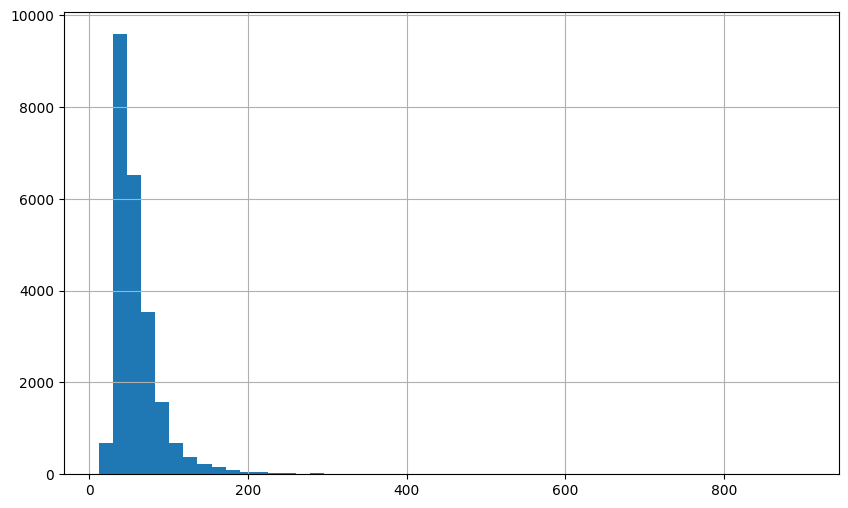

In [19]:
#Общая площадь
data_filled['total_area'].hist(bins=50, figsize=(10, 6))
data_filled['total_area'].describe()

In [20]:
#Судя по диаграмме, доля объектов более 300m2 крайне мала.
#Расчитаем процентое отношение таких объектов к общему кол-ву объектов.

len(data_filled[data_filled['total_area'] > 300]) / len(data_filled) * 100

0.25739482678594033

- Менее 1% объектов в данных имеют площадь более 300 м², что позволяет считать их редкими случаями.
- Учитывая, что эти объекты составляют небольшую долю, их можно исключить из дальнейшего анализа.


In [21]:
#Удалим редкие значения более 300 м²

data_cleaned = data_cleaned[data_cleaned['total_area'] < 300]

In [22]:
data_cleaned['total_area'].describe()

,total_area
count,23636.000000
mean,59.430665
std,30.461986
min,12.000000
25%,40.000000
50%,52.000000
75%,69.400000
max,297.500000


In [23]:
data_cleaned.shape[0] / data_filled.shape[0]

0.9973416599856534

#### Жилая площадь (living_area)

,living_area
count,21796.000000
mean,34.457852
std,22.030445
min,2.000000
25%,18.600000
50%,30.000000
75%,42.300000
max,409.700000


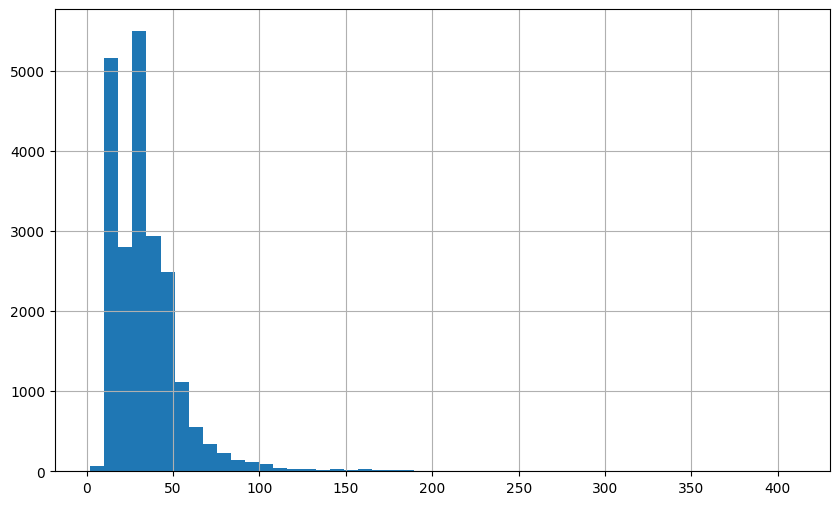

In [24]:
#Жилая площадь

data_filled['living_area'].hist(bins=50, figsize=(10, 6))
data_filled['living_area'].describe()

In [25]:
#Площадь менее 10 м² может быть выбросом
#Жилая площадь более 250 м² также может считаться выбросом
#Расчитаем процентое отношение таких объектов к общей массе.

print((len(data_filled[data_filled['living_area'] < 10]) / len(data_filled)) * 100)
print((len(data_filled[data_filled['living_area'] > 250]) / len(data_filled)) * 100)

0.10548968310899194
0.05907422254103549


- Менее 0.11% объектов в данных имеют жилую площадь менее 10 м², что позволяет считать их редкими случаями. Эти значения могут быть выбросами, так как жилая площадь менее 10 м² не является типичной для жилых помещений. Их можно исключить из дальнейшего анализа для улучшения точности.
- Менее 0.06% объектов в данных имеют жилую площадь более 250 м². Эти квартиры также являются редкими и могут относиться к элитным или нестандартным объектам. Учитывая их небольшую долю, такие квартиры можно исключить.

In [26]:
#Удалим редкие значения более 300 м²

data_cleaned = data_cleaned[(data_cleaned['living_area'] < 250) & (data_cleaned['living_area'] > 10)]

In [27]:
data_cleaned['living_area'].describe()

,living_area
count,21687.000000
mean,34.081032
std,19.753250
min,10.080000
25%,18.605000
50%,30.000000
75%,42.200000
max,225.900000


In [28]:
data_cleaned.shape[0] / data_filled.shape[0]

0.9151019030338833

#### Площадь кухни (kitchen_area)

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64


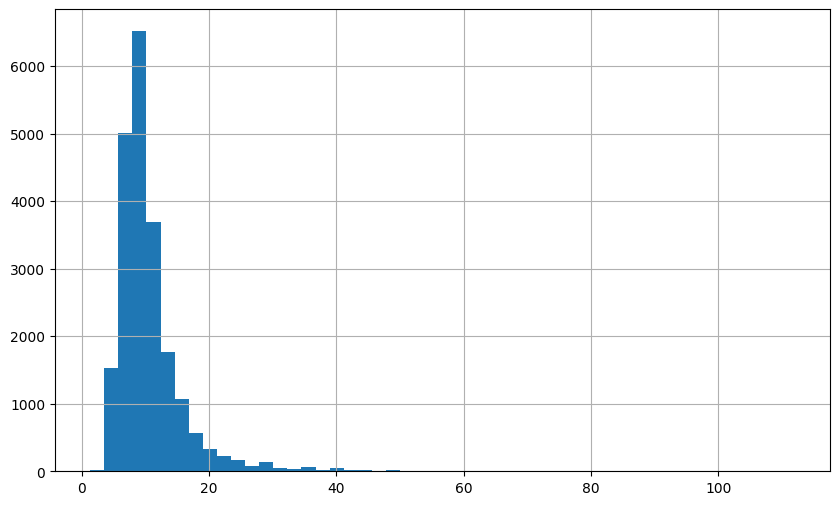

In [29]:
# Построим гистограмму для площади кухни
data_filled['kitchen_area'].hist(bins=50, figsize=(10, 6))

# Проверка на аномалии
print(data_filled['kitchen_area'].describe())

In [30]:
# Есть объекты с кухнями более 50 м², что является выбросом.
# Есть объекты с кухнями менее 5 м², что так же можно считать маловероятным.
# Рассчитаем процентое отношение таких объектов к общей массе.

print(len(data_filled[data_filled['kitchen_area'] > 50]) / len(data_filled) * 100)
print(len(data_filled[data_filled['kitchen_area'] < 5]) / len(data_filled) * 100)

0.19410101692054516
0.44305666905776614


- Менее 0.20% объектов в данных имеют кухню более 50 м², что позволяет считать их редкими случаями. Эти значения могут быть выбросами, так как жилая площадь более 50 м² не является типичной для жилых помещений. Их можно исключить из дальнейшего анализа для улучшения точности.
- Менее 0.44% объектов в данных имеют кухню менее 5 м². Эти объекты также являются редкими и могут относиться к нестандартным объектам. Учитывая их небольшую долю, такие квартиры можно исключить.

In [31]:
#Удалим редкие значения площади кухни более 50 и менее 5 м²

data_cleaned = data_cleaned[(data_cleaned['kitchen_area'] < 50) & (data_cleaned['kitchen_area'] > 5)]

In [32]:
data_cleaned['kitchen_area'].describe()

,kitchen_area
count,20393.000000
mean,10.461450
std,5.029867
min,5.040000
25%,7.100000
50%,9.200000
75%,12.000000
max,49.400000


In [33]:
data_cleaned.shape[0] / data_filled.shape[0]

0.8605004430566691

#### Цена объекта (last_price)

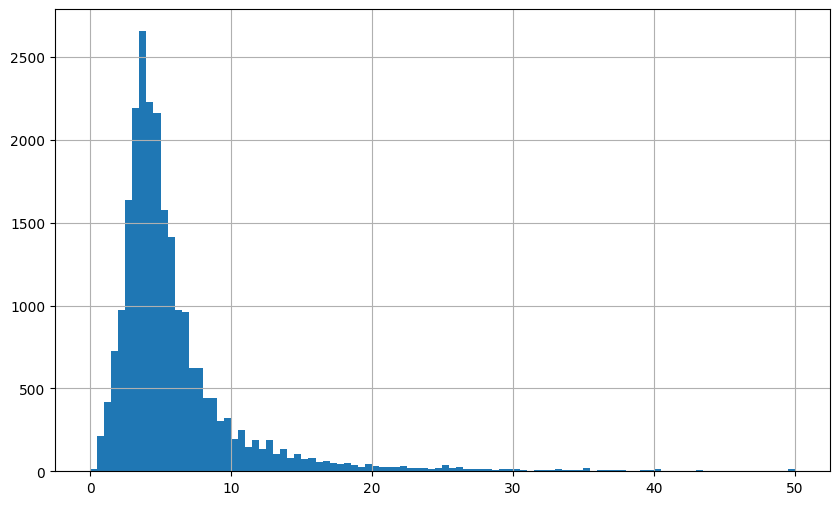

,last_price
count,23699.000000
mean,6.541549
std,10.887013
min,0.012190
25%,3.400000
50%,4.650000
75%,6.800000
max,763.000000


In [34]:
#Построим гистограмму

data_filled['last_price'] = data_filled['last_price'] / 1000000
data_filled['last_price'].hist(bins=100, figsize=(10, 6), range=(0,50))
plt.show()

#Проверка на аномалии
data_filled['last_price'].describe()

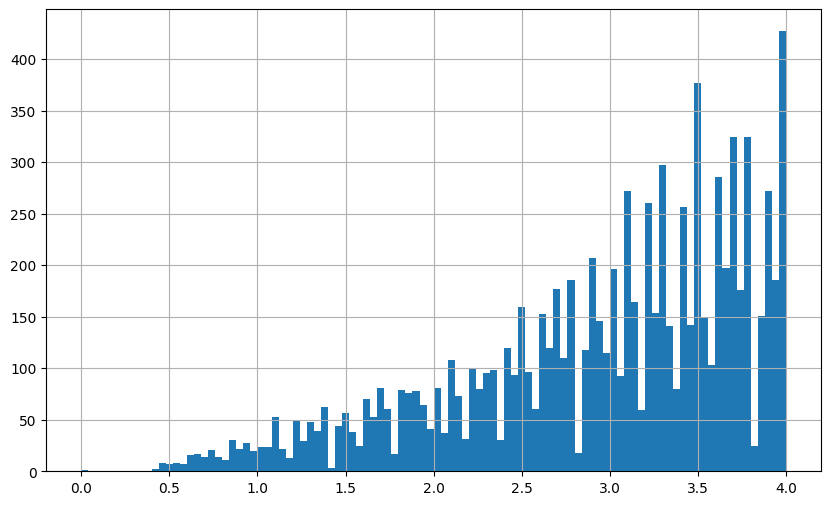

In [35]:
# Минимальная стоимость объекта менее 15 000, в то время как верхний 763 000 000 руб.
# Посмотрим на нижний и верхний диапазон значений диаграммы отдельно.

# Количество объектов стоимостью от 0 до 4 000 000 руб.

data_filled['last_price'].hist(bins=100, figsize=(10, 6), range=(0,4))
plt.show()

- На гистограмме выше видно, что цены объектов ниже 500000 встречаются крайне редко и выбиваются из общей картины

<Axes: >

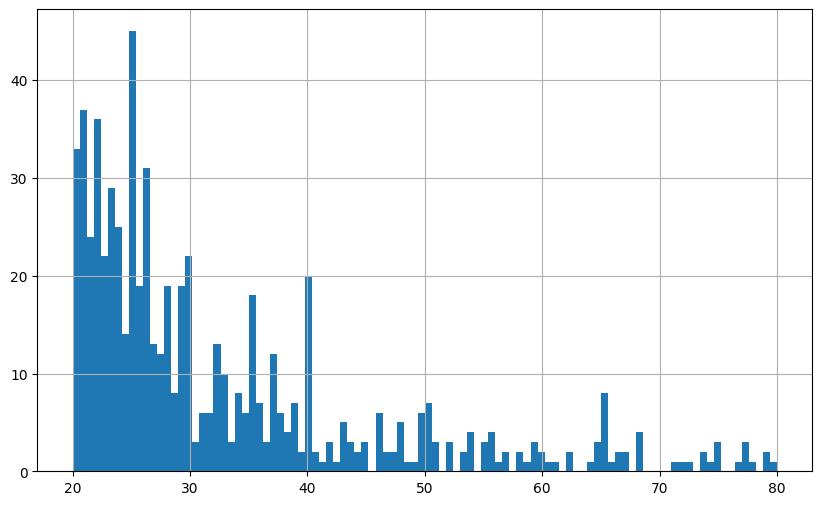

In [36]:
# Количество объектов стоимостью от 20 000 000 до 80 000 000 руб.

data_filled['last_price'].hist(bins=100, figsize=(10, 6), range=(20, 80))

Минимальная стоимость объектов недвижимости составляет менее 15 000 рублей, а максимальная — 763 000 000 рублей, что свидетельствует о большом диапазоне цен в данных.

При рассмотрении нижнего диапазона стоимости объектов, большинство квартир имеют цену до 4 000 000 рублей. Это подтверждает, что значительная часть объектов находится в среднем ценовом сегменте.

Однако, при анализе верхнего диапазона (от 20 000 000 до 80 000 000 рублей), столбцы начиная с 70 000 000 рублей встречаются крайне редко и находятся далеко от основного скопления данных. Эти объекты можно считать выбросами, так как они не представляют типичные объекты на рынке недвижимости. Учитывая их редкость, их можно исключить из дальнейшего анализа, чтобы не искажать результаты исследования.

Таким образом, выбросы в ценовом диапазоне ниже 500000 и свыше 70 000 000 рублей не оказывают значительного влияния на общие выводы по рынку стандартных объектов и могут быть исключены для улучшения качества анализа.

In [37]:
data_cleaned['last_price'] = data_cleaned['last_price'] / 1000000
data_cleaned = data_cleaned[(data_cleaned['last_price'] < 70) & (data_cleaned['last_price'] > 0.5)]

In [38]:
data_cleaned['last_price'].describe()

,last_price
count,20347.000000
mean,6.123405
std,5.253004
min,0.520000
25%,3.500000
50%,4.700000
75%,6.800000
max,68.500000


In [39]:
data_cleaned.shape[0] / data_filled.shape[0]

0.8585594328874636

#### Количество комнат (rooms)

,rooms
count,23699.000000
mean,2.070636
std,1.078405
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,19.000000


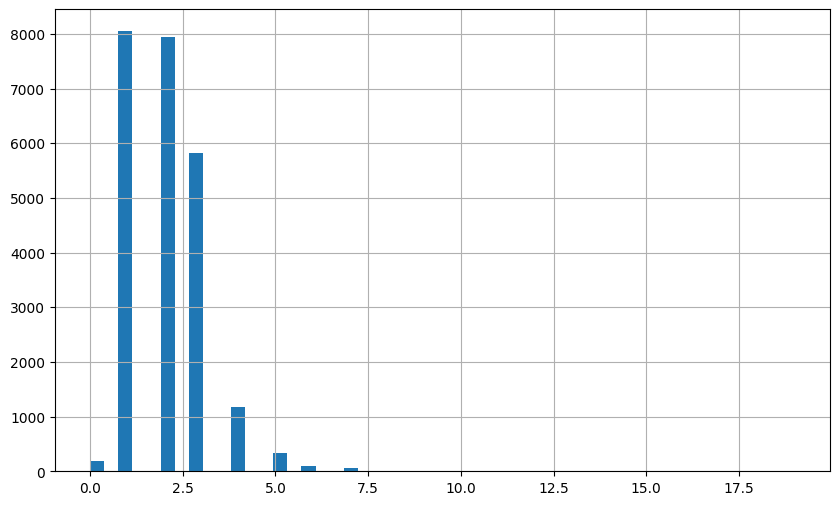

In [40]:
# Построим гистограмму для колечства комнат в объектах
data_filled['rooms'].hist(bins=50, figsize=(10, 6))

#Проверка на аномалии
data_filled['rooms'].describe()

- Глядя на данные, можно сказать, что объекты недвижимости с менее, чем 1 и более 7.5 комнат можно считать выбросами.

In [41]:
data_cleaned = data_cleaned[(data_cleaned['rooms'] <= 7.5) & (data_cleaned['rooms'] >= 1)]

In [42]:
data_cleaned['rooms'].describe()

,rooms
count,20332.000000
mean,2.078300
std,1.004083
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,7.000000


In [43]:
data_cleaned.shape[0] / data_filled.shape[0]

0.8579264947888097

#### Высота потолков (ceiling_height)

,ceiling_height
count,23699.000000
mean,2.724358
std,0.988298
min,1.000000
25%,2.600000
50%,2.650000
75%,2.700000
max,100.000000


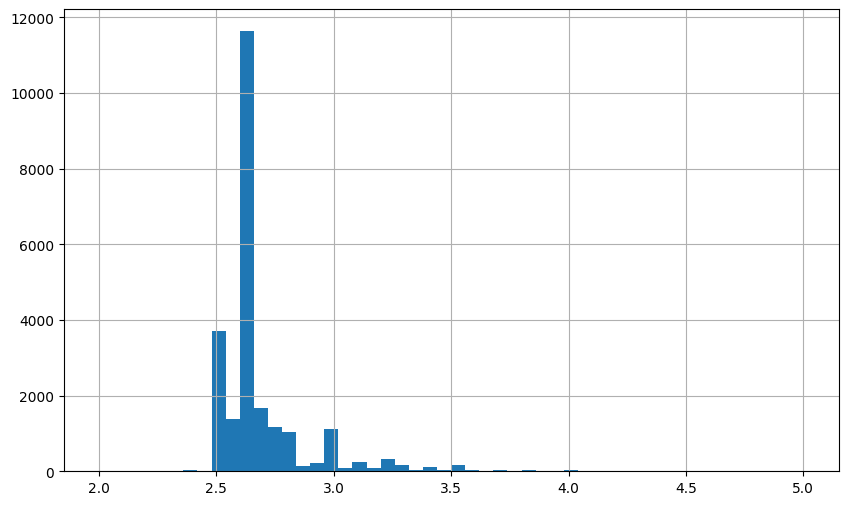

In [44]:
# Построим гистограмму
data_filled['ceiling_height'].hist(bins=50, figsize=(10, 6), range=(2,5))

# Проверим на аномалии
data_filled['ceiling_height'].describe()

- В глаза бросаются значения высоты потолков менее 2 и более 4 м.
- Стандартное отклонение невелико, а среднее, медианное и квартили находятся на близких значениях, из чего напрашивается вывод, что выборсы в данных незначительно сказываются на их качестве, но все равно от выдающихся значений лучше избавиться

In [45]:
data_cleaned = data_cleaned[(data_cleaned['ceiling_height'] <= 4) & (data_cleaned['ceiling_height'] >= 2)]

In [46]:
data_cleaned['ceiling_height'].describe()

,ceiling_height
count,20274.000000
mean,2.693215
std,0.204997
min,2.000000
25%,2.600000
50%,2.650000
75%,2.700000
max,4.000000


In [47]:
data_cleaned.shape[0] / data_filled.shape[0]

0.855479134140681

#### Тип этажа квартиры (floor_type)

<Axes: xlabel='floor_type'>

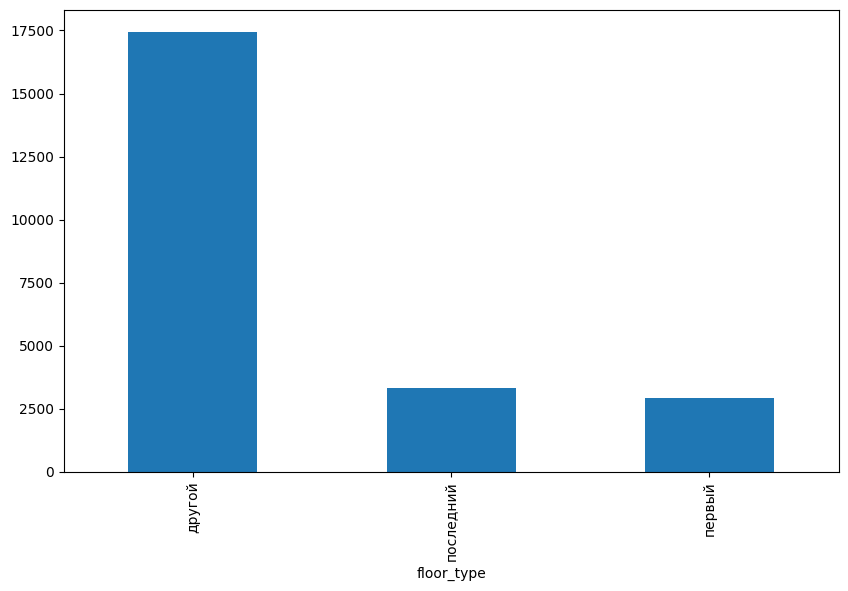

In [48]:
# Построим гистограмму для типов этажей
data_filled['floor_type'].value_counts().plot(kind='bar', figsize=(10, 6))

- Распределение выглядит сблансированным, корректировка не требуется.

#### Общее количество этажей в доме ('floors_total')

,floors_total
count,23613.0
mean,10.673824
std,6.597173
min,1.0
25%,5.0
50%,9.0
75%,16.0
max,60.0


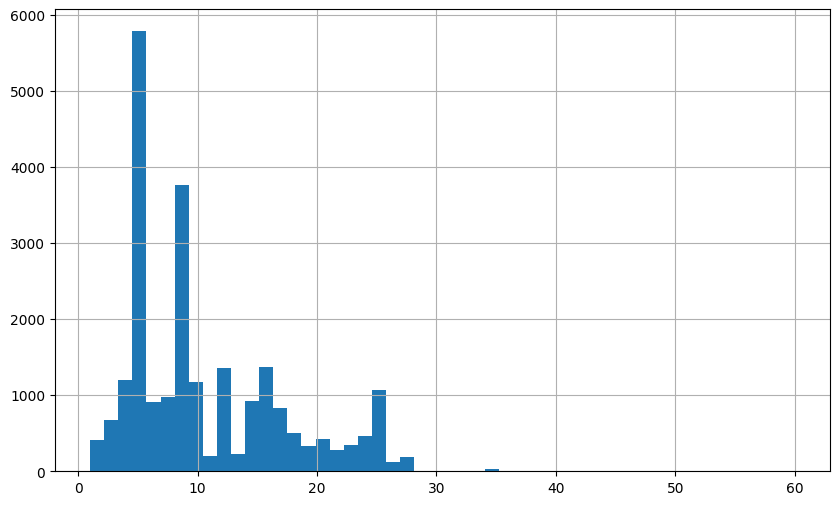

In [49]:
# Построим гистограмму
data_filled['floors_total'].hist(bins=50, figsize=(10, 6))

#Проверим на аномалии
data_filled['floors_total'].describe()

- Большинство зданий, в которых расположены объекты имеют высотность до 30 этажей.

####  Расстояние до центра города в метрах (cityCenters_nearest)

,cityCenters_nearest
count,18180.000000
mean,14191.277833
std,8608.386210
min,181.000000
25%,9238.000000
50%,13098.500000
75%,16293.000000
max,65968.000000


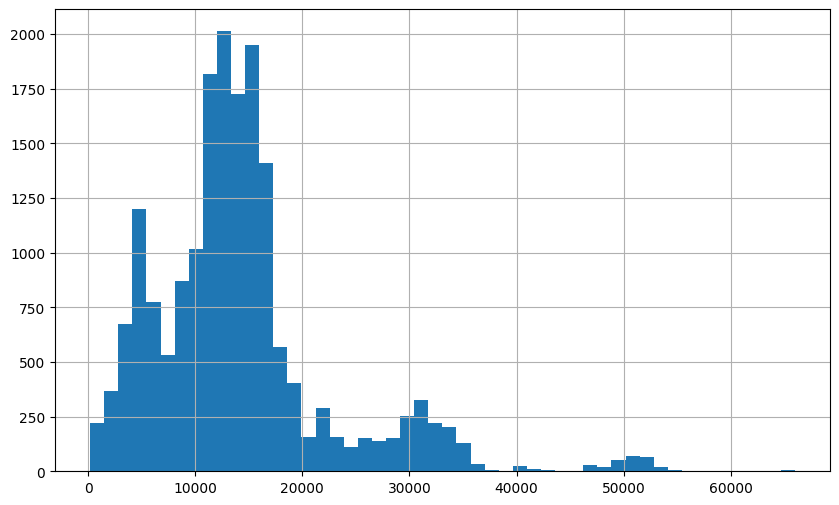

In [50]:
# Построим гистограмму
data_filled['cityCenters_nearest'].hist(bins=50, figsize=(10, 6))

# Проверим на аномалии
data_filled['cityCenters_nearest'].describe()

- Большинство объектов находится на расстоянии от 9 до 17 км от центра города.
- Небольшое количество отдельностоящих объектов с расстоянием более 45 км может рассматриваться как выбросы, однако учитывая специфику исследования, отбрасывать эти значения нет необходимостти

In [51]:
data_cleaned['cityCenters_nearest'].describe()

,cityCenters_nearest
count,15823.000000
mean,14212.870315
std,8504.075128
min,181.000000
25%,9436.000000
50%,13142.000000
75%,16226.000000
max,65968.000000


In [52]:
data_cleaned.shape[0] / data_filled.shape[0]

0.855479134140681

#### Расстояние до ближайшего парка (parks_nearest)

,parks_nearest
count,8079.000000
mean,490.804555
std,342.317995
min,1.000000
25%,288.000000
50%,455.000000
75%,612.000000
max,3190.000000


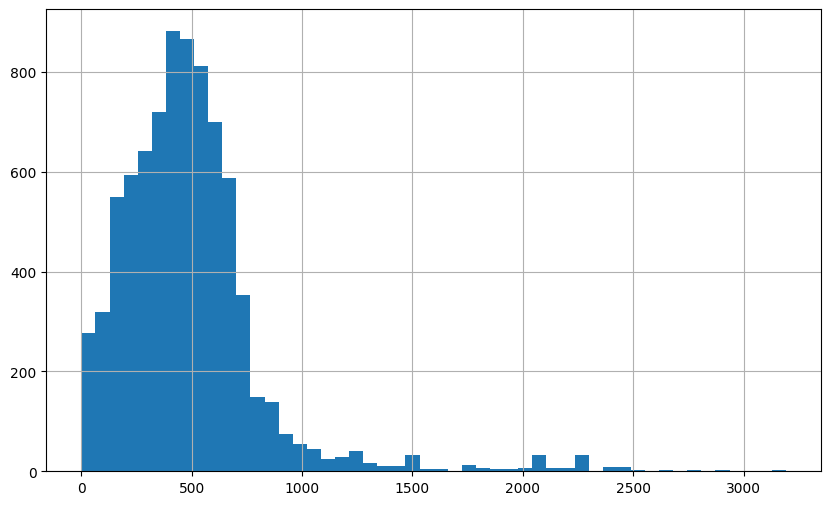

In [53]:
# Построим гистограмму
data_filled['parks_nearest'].hist(bins=50, figsize=(10, 6))

# Проверим на аномалии
data_filled['parks_nearest'].describe()

- Большинство объектов находится в пределах до 1 км от ближайшего парка.
- Объекты с расстоянием более 2.5 км до ближайшего парка могут считаться более редкими, но нет объектов удаленных от зеленых зон более, чем на 3,5 км.

#### Общие выводы / Major insights (EDA)

🔷 **Section Data sidenote**

Preprocessing reduced the impact of rare and extreme values, leaving a cleaner dataset for modeling and factor analysis. Typical objects are now better represented, supporting more reliable insights into pricing in St. Petersburg and surroundings.

Key outlier handling focused on: last_price (apartment cost), сeiling_height, rooms, total_area

---

В результате проведённой предобработки данных удалось значительно уменьшить влияние редких и выбивающихся значений на последующий анализ. Выделенные типичные объекты и данные теперь могут быть использованы для построения более точных моделей и выявления факторов, влияющих на рыночную стоимость объектов недвижимости в Санкт-Петербурге и его окрестностях.

- Основные столбцы, где были поработаны выбросы, это: стоимость квартиры ['last_price'], высота потолков ['ceiling_height'], количество комнат ['rooms'] и общая площадь ['total_area']

In [74]:
data_cleaned[['last_price', 'ceiling_height', 'rooms', 'total_area']].describe()

,last_price,ceiling_height,rooms,total_area
count,20274.00,20274.00,20274.00,20274.00
mean,6.09,2.69,2.08,59.55
std,5.18,0.20,1.00,28.46
min,0.52,2.00,1.00,20.00
25%,3.50,2.60,1.00,40.60
50%,4.70,2.65,2.00,52.70
75%,6.80,2.70,3.00,70.00
max,68.50,4.00,7.00,297.50


### Как быстро продавались квартиры (days_exposition)? / How quickly were the apartments sold (days_exposition)?

🔷 **Section Data sidenote**

Sale time is right-skewed: median ≈ 102 days vs mean ≈ 185 days, indicating a long tail of slow deals.
Typical time-to-sell: ~3–4 months (≈100 days).
Fast sales: < ~100 days.
Unusually long: > ~185 days (likely niche/overpriced listings).
These thresholds help segment listings and explain mean–median divergence.

🔶 **Section Code sidenote**

What: plot days_exposition histogram (100 bins, labels, grid); compute median() and mean() to quantify central tendency.

Why: visualize market speed and detect skew/outliers; use median as robust “typical” time.

Outcome: median ~102d, mean ~185d → define fast/slow buckets for later analyses (e.g., pricing, features). Report share of listings in fast/slow groups.

---

Построим гистограмму, посчитаем среднее и медиану.
Составим вывод, сколько времени обычно занимает продажа.
Какие продажи можно считать быстрыми, а какие — необычно долгими?

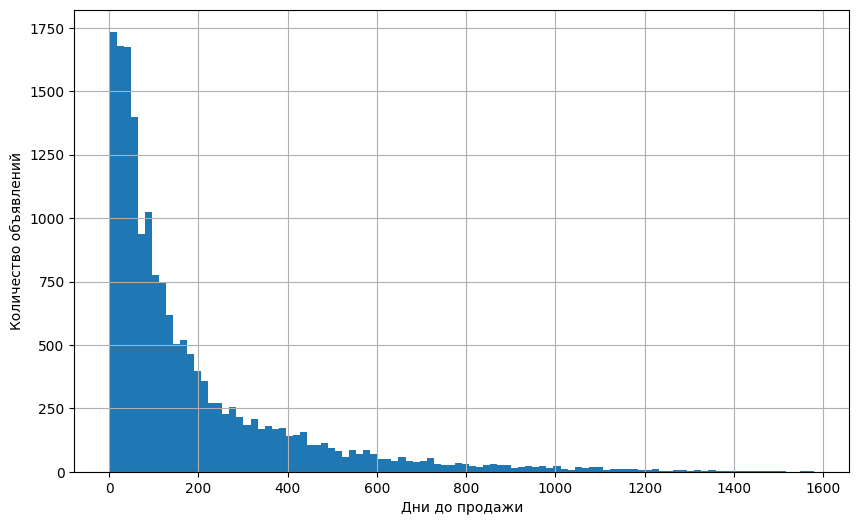

In [57]:
#Построим гистограмму
data_cleaned['days_exposition'].plot(
    kind='hist',
    bins=100,
    figsize=(10,6)
)

# Добавляем подписи осей и сетку
plt.xlabel('Дни до продажи')
plt.ylabel('Количество объявлений')
plt.grid(True)

- По гистограмме видно, что большинство объектов продается в срок быстрее 200 дней с момента публикации

In [58]:
# Рассчитаем медиану и среднее для срока продажи объекта

median_exposition = data_cleaned['days_exposition'].median()
mean_exposition = data_cleaned['days_exposition'].mean()

print(f"Медиана: {median_exposition:.1f} дней")
print(f"Среднее: {mean_exposition:.1f} дней")

Медиана: 102.0 дней
Среднее: 184.8 дней


- Медиана: 102 дня — это время, за которое продается половина объектов. Это означает, что 50% всех объектов недвижимости продаются за 102 дня или быстрее. Это значение является типичным для рынка и может служить ориентиром для того, что считается «нормальной» продолжительностью времени продажи.


- Среднее: 185 дней — среднее время продажи, которое больше медианы. Разница между средним и медианой говорит о наличии выбросов, то есть небольшого числа объектов, которые продаются значительно дольше (например, несколько лет). Эти выбросы увеличивают среднее значение, но медиана более точно отражает типичное время продажи.

**Вывод:**

- Большинство объектов продается за 3-4 месяца (102 дня).
- Продажи, которые занимают больше 184.8 дней, могут считаться необычно долгими, и они скорее всего связаны с нестандартными объектами или неудачными условиями продажи (например, завышенной ценой).
- Продажи, которые происходят за менее чем 100 дней, можно считать быстрыми, это характерно для объектов, которые соответствуют рыночной стоимости или имеют высокую привлекательность.

### Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта. / Identify the factors that most influence the total property price.

🔷 **Section Data sidenote**

Strongest price drivers (Pearson): total_area ≈ 0.77, living_area ≈ 0.67, kitchen_area ≈ 0.57, rooms ≈ 0.48.
Raw floor has very weak linear link (≈0.05), but the categorical floor_type shows the expected pattern: last floor pricier, first cheaper, other in between.
Calendar features: weekday/month ~ flat; year reflects macro regime (high in 2014, decline to 2016, then stable/slightly up). Posting date is a weak cross-sectional predictor vs. physical attributes.

🔶 **Section Code sidenote**

What: build data_new with price + core numerics; plot scatter_matrix; compute corr(); compute/plot mean last_price by weekday_exposition, month_exposition, year_exposition; pivot & bar for floor_type.

Why: quantify linear relationships, surface calendar patterns, and test vertical-position effects in a categorical form.

Outcome: size features dominate; floor_type matters directionally; posting day/month negligible; year captures market cycles.

---

Построим графики, которые показывают зависимость цены от параметров:

  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - количество комнат;
  - тип этажа, на котором расположена квартира (первый, последний, другой);
  - дата размещения (день недели, месяц, год).

In [59]:
# Поместим в новый датафрейм нужные для определения корреляции c 'last_price' столбцы (кроме даты размещения)

data_new = data_cleaned[['last_price','total_area', 'living_area', 'kitchen_area', 'rooms', 'floor']]

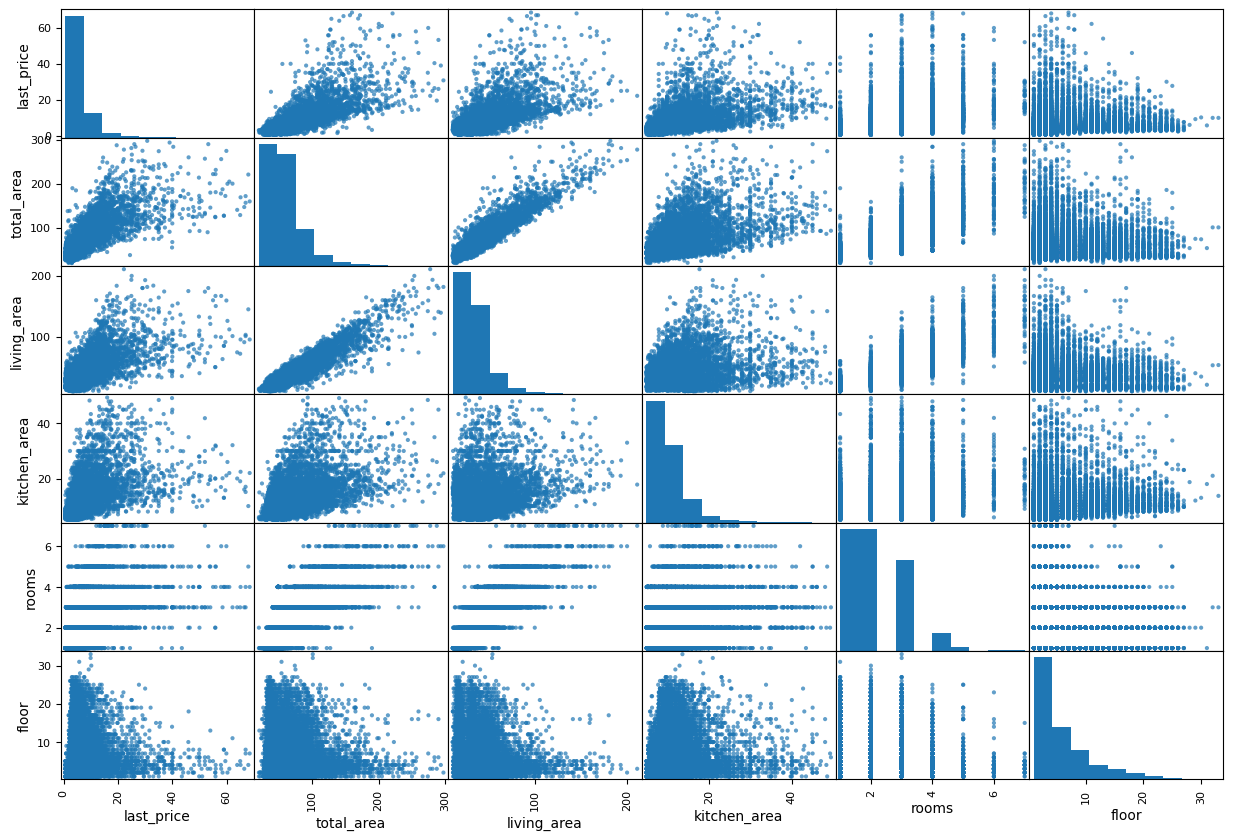

In [60]:
# Построим диаграмму рассеивания для визуального представления взаимосвязи столбцов

scatter_matrix(data_new, figsize=(15, 10), alpha=0.7)
plt.show()

- Для лучшей интерпритации результатов посмотрим на матрицу корреляции ниже

In [61]:
# Построим матрицу корреляции для получения точного значения коэффициента

data_new.corr()

,last_price,total_area,living_area,kitchen_area,rooms,floor
last_price,1.000000,0.765792,0.670105,0.567315,0.483035,0.054187
total_area,0.765792,1.000000,0.934354,0.579189,0.793309,-0.020004
living_area,0.670105,0.934354,1.000000,0.368869,0.872926,-0.103587
kitchen_area,0.567315,0.579189,0.368869,1.000000,0.228619,0.158282
rooms,0.483035,0.793309,0.872926,0.228619,1.000000,-0.148135
floor,0.054187,-0.020004,-0.103587,0.158282,-0.148135,1.000000


На основании обновленной корреляционной матрицы можно сделать следующие выводы о факторах, влияющих на общую стоимость объекта:

1.	Общая площадь (total_area):
- Корреляция с ценой составляет 0.77. Это подтверждает, что общая площадь остается основным фактором, оказывающим наибольшее влияние на стоимость квартиры. Чем больше площадь, тем выше цена, и это закономерное соотношение отражено высокой корреляцией.

2.	Жилая площадь (living_area):
- Корреляция с ценой 0.67. Жилая площадь также сильно влияет на стоимость объекта, но немного меньше, чем общая площадь. Это логично, так как большее количество жилой площади делает квартиру более привлекательной и дорогой, но наличие дополнительных нежилых зон также имеет значение.

3.	Площадь кухни (kitchen_area):
- Корреляция с ценой 0.57. Площадь кухни имеет умеренное влияние на цену. Это означает, что большие кухни в квартирах могут быть связаны с более высокими ценами, но их влияние меньше, чем у общей и жилой площади. Тем не менее, наличие просторной кухни добавляет ценность объекту.

4.	Количество комнат (rooms):
- Корреляция с ценой 0.48. Количество комнат оказывает слабое влияние на цену. Хотя логично, что квартиры с большим количеством комнат обычно стоят дороже, эта связь не так выражена, как с общей площадью. Вероятно, это связано с тем, что значение имеет не только количество комнат, но и их размеры и планировка.

5.	Тип этажа (floor):
- Корреляция с ценой 0.05 — крайне низкая. Это указывает на то, что тип этажа почти не влияет на стоимость квартиры в данном наборе данных. Возможно, для оценки влияния типа этажа стоит учитывать дополнительные факторы, такие как состояние здания или его престижность, а также общие условия проживания.

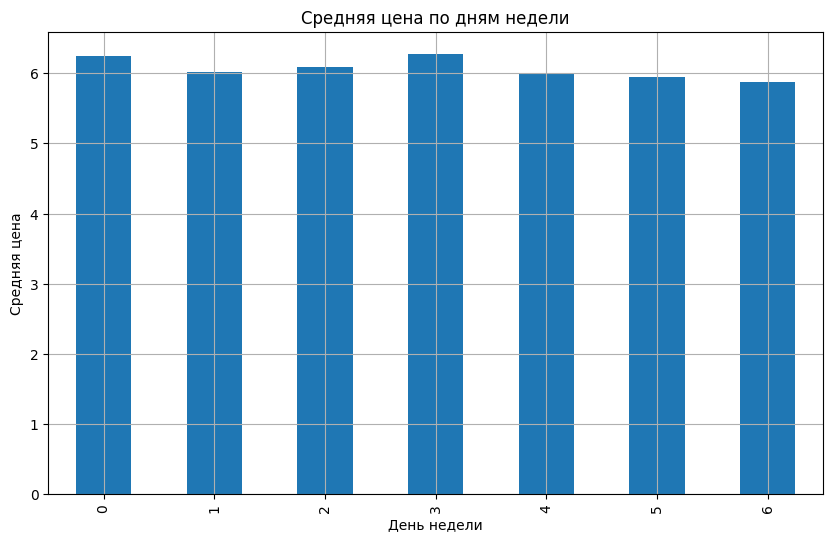

In [62]:
# Для опеределения взаимосвязи даты публикации и стоимости продажи выявим среднюю стоимость проданного /
# объекта для каждого дня недели, месяца и года

# Средняя цена для каждого дня недели
weekday_pivot = data_cleaned.pivot_table(index='weekday_exposition', values='last_price', aggfunc='mean')

# Построим столбчатую диаграмму для средней цены по дням недели
fig, ax = plt.subplots(figsize=(10, 6))
weekday_pivot.plot(kind='bar', legend=False, ax=ax)
plt.title('Средняя цена по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средняя цена')
plt.grid(True)
plt.show()

Равномерное распределение: В целом, средняя стоимость объектов недвижимости остается довольно стабильной в течение недели. Нет ярко выраженного пика или падения цен, которые могли бы свидетельствовать о зависимости стоимости от дня публикации объявления.

Таким образом, день публикации объявления не является существенным фактором, влияющим на стоимость недвижимости.

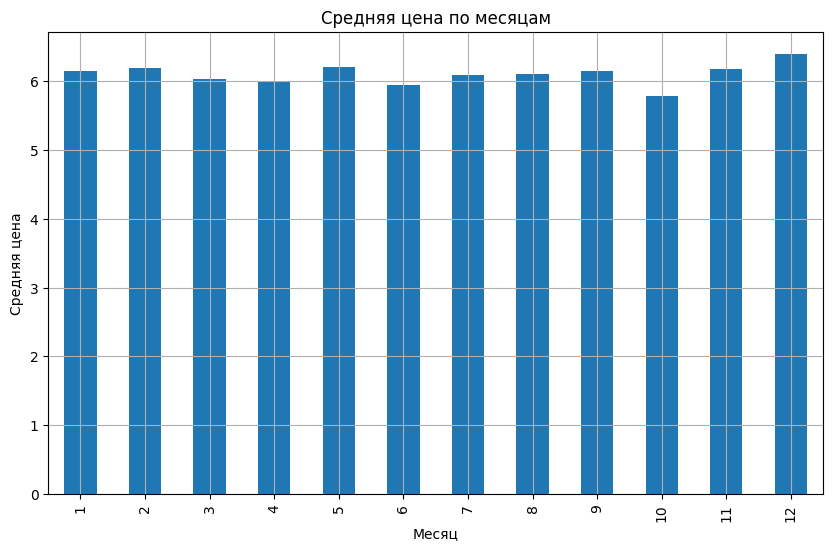

In [63]:
# Средняя цена для каждого месяца
month_pivot = data_cleaned.pivot_table(index='month_exposition', values='last_price', aggfunc='mean')

# Построим столбчатую диаграмму для средней цены по месяцам
fig, ax = plt.subplots(figsize=(10, 6))
month_pivot.plot(kind='bar', legend=False, ax=ax)
plt.title('Средняя цена по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя цена')
plt.grid(True)
plt.show()

По диаграмме выше можно сделать следующие выводы:

- Стабильность цен: Средняя стоимость недвижимости в течение года остаётся относительно стабильной, без резких всплесков или падений. Это свидетельствует о том, что цена не сильно зависит от месяца публикации.
- Небольшие колебания: На диаграмме видны незначительные колебания. Самая высокая средняя цена наблюдается в декабре, а самая низкая — в ноябре. Однако отклонение незначительное, можно отнести к погрешности.

Таким образом, месяц публикации объявления не является значимым фактором для определения цены продажи объекта недвижимости.

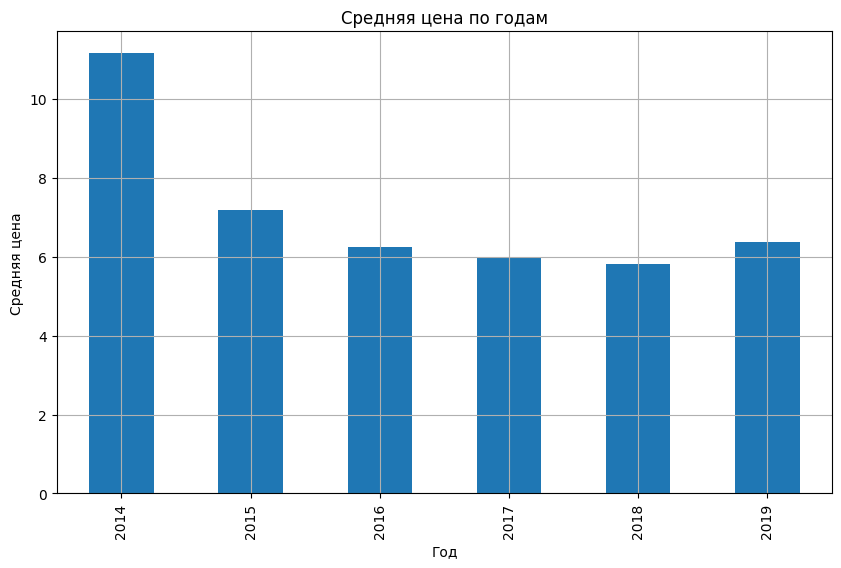

In [64]:
# Средняя цена для каждого года
year_pivot = data_cleaned.pivot_table(index='year_exposition', values='last_price', aggfunc='mean')

# Построим столбчатую диаграмму для средней цены по годам
fig, ax = plt.subplots(figsize=(10, 6))
year_pivot.plot(kind='bar', legend=False, ax=ax)
plt.title('Средняя цена по годам')
plt.xlabel('Год')
plt.ylabel('Средняя цена')
plt.grid(True)
plt.show()

По диаграмме, отражающей среднюю цену объектов недвижимости по годам, можно сделать следующие выводы:

1.	Резкое падение цены: В 2014 году средняя цена объектов недвижимости была значительно выше по сравнению с последующими годами. Это может быть связано с экономическими изменениями или другими внешними факторами, которые привели к снижению стоимости сделок с недвижимостью.
2.	Стабилизация цены: Начиная с 2016 года, средняя цена постепенно стабилизируется, не показывая значительных колебаний. В 2018 и 2019 годах наблюдается относительная стабильность с намеком на восходящий тренд.
3.	Тренд на снижение: С 2014 по 2017 год прослеживается явный тренд на снижение средней цены, что может указывать на влияние внешних факторов на рынок недвижимости в этот период.

Таким образом, год публикации объявления является важным фактором для определения стоимости недвижимости, и в анализе данных необходимо учитывать изменения в экономике для объяснения колебаний цен.

**Расчет средней цена квартиры в зависимости от категории этажа**

            last_price
floor_type            
другой        6.340811
последний     5.962629
первый        4.719202


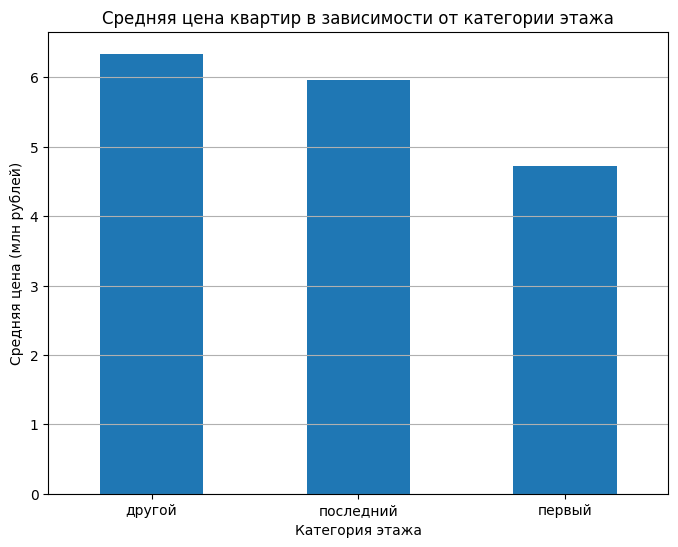

In [65]:
# Создадим сводноую таблицу для  изучения средней цены по категориям этажей

floor_price_pivot = data_cleaned.pivot_table(index='floor_type', values='last_price', aggfunc='mean').sort_values(by='last_price', ascending=False)
print(floor_price_pivot)

# 2. Построим график для сравнения средней цены квартир по категориям этажей

fig, ax = plt.subplots(figsize=(8, 6))
floor_price_pivot.plot(kind='bar', legend=False, ax=ax)
plt.title('Средняя цена квартир в зависимости от категории этажа')
plt.xlabel('Категория этажа')
plt.ylabel('Средняя цена (млн рублей)')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

Категория этажа оказывает заметное влияние на стоимость квартиры:

- Последний этаж ценится выше остальных, вероятно, благодаря уникальным преимуществам.
- Квартиры на первом этаже стоят дешевле, что может быть связано с определенными недостатками.
- "Другие" этажи находятся в среднем диапазоне, являясь сбалансированным вариантом для большинства покупателей.


**Заключение по результатам анализа по выявлению взаимосвязи между характеристиками объекта и ценой продажи:**

Дата публикации объявления, включая день недели, месяц и год, не оказывает значительного влияния на стоимость объекта. Основные колебания цен, наблюдаемые по годам, могут быть вызваны внешними факторами, такими как экономические условия. Остальные факторы, такие как общая площадь, жилая площадь, количество комнат и другие физические характеристики квартиры, оказывают большее влияние на формирование цены объекта, чем время публикации объявления.

### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений / Calculating the average price of one square meter in 10 localities with the largest number of ads

🔷 **Section Data sidenote**

Top-10 localities by ad count are heavily dominated by St. Petersburg (13,681 ads), with suburban clusters like Murino (417), Shushary (384), and Vsevolozhsk (353) reflecting spillover demand into commuter zones.

High end: Repino (≈150k), St. Petersburg (≈116k), Zelenogorsk (≈114k), Pushkin (≈106k), Bor (≈106k). Drivers: prestige, resort/eco appeal, historic-cultural status, constrained supply.

Low end: Sovkhozny, Efimovsky, Malaya Romanovka, Tesovo-4, Vyskatka — all remote, low-demand, infrastructure-poor areas, which depresses prices.

The spatial gradient is clear: central metro + prestige suburbs = premium, remote/depressed areas = discount.

🔶 **Section Code sidenote**

What: built pivot by locality, added ad counts, computed price_per_sqm, ranked by ads and price extremes.

Why: to compare markets on both activity (num_ads) and standardized price metric.

Outcome: St. Petersburg + prestige suburbs show high prices; remote villages reveal structural low-price segment.

---

- построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов
- выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [66]:
# Построим сводную таблицу, в значениях которой будет средняя цена продажи и площадь объекта по населенным пунктам

pivot_table_locality = data_cleaned.pivot_table(
    index='locality_name',
    values=['last_price', 'total_area'],
)

# Так же создадим столбец с количеством объявлений объявлений в каждом населенном пункте и рассчитаем значения

pivot_table_locality['num_ads'] = data_cleaned.groupby('locality_name')['last_price'].count()

# Выведем топ-10 населенных пунктов по кол-ву объявлений

pivot_table_locality.sort_values(by='num_ads', ascending=False).head(10)

,last_price,total_area,num_ads
locality_name,,,
санкт-петербург,7.281891,62.975434,13681
поселок мурино,3.855231,46.580168,417
поселок шушары,4.144641,54.209661,384
всеволожск,3.830309,56.268272,353
колпино,3.889550,52.799840,312
пушкин,6.457034,61.154603,302
поселок парголово,4.510054,51.262857,287
гатчина,3.575017,51.981293,263
деревня кудрово,4.460925,49.118214,224


- Таблица показывает, что наибольшее количество объявлений о продаже недвижимости сосредоточено в Санкт-Петербурге (13,681 объявлений), что значительно превосходит остальные населённые пункты. Это подтверждает высокую активность и спрос на рынке недвижимости в мегаполисе.

- Помимо Санкт-Петербурга, популярными для размещения объявлений являются ближайшие пригороды, такие как поселок Мурино (417 объявлений), Шушары (384 объявлений) и Всеволожск (353 объявлений). Это свидетельствует о растущем интересе к покупке недвижимости в пригородных зонах, где, вероятно, более доступные цены на жильё по сравнению с городом.


In [67]:
#Добавим в получившуюся таблицу столбец с ценой за квадратный метр и рассчитаем значения(цена в млн./руб.)

pivot_table_locality['price_per_sqm'] = pivot_table_locality['last_price'] / pivot_table_locality['total_area']
pivot_table_locality.sort_values(by='num_ads', ascending=False).head(10)

,last_price,total_area,num_ads,price_per_sqm
locality_name,,,,
санкт-петербург,7.281891,62.975434,13681,0.115631
поселок мурино,3.855231,46.580168,417,0.082766
поселок шушары,4.144641,54.209661,384,0.076456
всеволожск,3.830309,56.268272,353,0.068072
колпино,3.889550,52.799840,312,0.073666
пушкин,6.457034,61.154603,302,0.105585
поселок парголово,4.510054,51.262857,287,0.087979
гатчина,3.575017,51.981293,263,0.068775
деревня кудрово,4.460925,49.118214,224,0.090820


In [68]:
# Средняя цена за квадратный метр в 10 населённых пунктах с наибольшим числом объявлений(цена в млн./руб.)

top_10 = pivot_table_locality.sort_values(by='num_ads', ascending=False).head(10)
top_10_mean = top_10['price_per_sqm'].mean()
top_10_mean

np.float64(0.08542829818435269)

Результат показывает, что **средняя цена за квадратный метр в 10 населённых пунктах с наибольшим числом объявлений** составляет 85,428 рублей.



In [69]:
# Найдём населённые пункты с самой высокой ценой за квадратный метр

print(pivot_table_locality['price_per_sqm'].nlargest(5))

locality_name
поселок репино     0.150463
санкт-петербург    0.115631
зеленогорск        0.113773
пушкин             0.105585
деревня бор        0.105539
Name: price_per_sqm, dtype: float64


Как видно из результатов, поселок Репино занимает первое место по стоимости квадратного метра (150 тыс. руб.), что можно объяснить его статусом престижного курортного пригорода с ограниченным предложением и высоким спросом на элитную недвижимость.

Санкт-Петербург ожидаемо занимает второе место (116 тыс. руб.). Высокие цены обусловлены статусом крупного мегаполиса с развитой инфраструктурой, экономическими возможностями и высоким спросом на жилье в центральных районах.

Также в топ-5 вошли:

- Зеленогорск (114 тыс. руб.), который является популярным курортным пригородом, известным своей благоприятной экологией и местами отдыха на побережье Финского залива.
- Пушкин (106 тыс. руб.), исторически значимый город с престижной жилой недвижимостью и хорошей инфраструктурой, что делает его привлекательным для проживания.
- Деревня Бор (106 тыс. руб.) с редкими, но высоко оцененными объектами недвижимости, что может быть связано с уникальными характеристиками или элитными объектами на данной территории.

Таким образом, данные подтверждают, что высокие цены на квадратный метр характерны для центральных районов Санкт-Петербурга и престижных пригородов с привлекательной экологией и развитой инфраструктурой.

In [70]:
# Найдём населённые пункты с самой низкой ценой за квадратный метр

print(pivot_table_locality['price_per_sqm'].nsmallest(5))

locality_name
поселок совхозный          0.012556
поселок ефимовский         0.012687
деревня малая романовка    0.012725
поселок тесово-4           0.012931
деревня выскатка           0.013208
Name: price_per_sqm, dtype: float64


Эти населённые пункты отличаются низкой ценой за квадратный метр, что в первую очередь связано с их удалённостью от центра Санкт-Петербурга и менее развитой инфраструктурой. Такие объекты находятся в менее привлекательных для массового покупателя местах, где спрос на недвижимость ниже, что объясняет низкие цены.

Выводы, сделанные ранее о Ломоносове, Красном Селе и Колпино, а также посёлках с менее развитой инфраструктурой, остаются актуальными. В подобных отдалённых районах можно наблюдать схожую тенденцию снижения стоимости квадратного метра из-за меньшего спроса и слабого развития локальной инфраструктуры.

**Общий вывод о разделе 4.14:**
Разница в стоимости квадратного метра между населёнными пунктами с самой высокой и самой низкой ценой остаётся значительной. Основной причиной этого является их расположение и уровень спроса на недвижимость в этих регионах. Санкт-Петербург, а также популярные курортные и исторические пригороды, такие как Поселок Репино, Зеленогорск и Пушкин, демонстрируют высокие цены за квадратный метр благодаря развитой инфраструктуре, престижности и близости к мегаполису.

С другой стороны, населённые пункты с самой низкой стоимостью квадратного метра, такие как Поселок Совхозный, Поселок Ефимовский, Деревня Малая Романовка, Поселок Тесово-4 и Деревня Выскатка, расположены вдали от центра Санкт-Петербурга и отличаются низким уровнем спроса и менее развитой инфраструктурой. Это делает недвижимость в этих регионах более доступной по цене.

Таким образом, центральные районы и популярные пригороды остаются более дорогими, в то время как отдалённые населённые пункты предлагают более низкие цены на жильё, что связано с их географическим положением и уровнем развития.

### Выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим их среднюю стоимость на разном удалении от центра. / Selecting apartments in Saint Petersburg using the locality_name column and calculate their average cost at different distances from the center.

🔷 **Section Data sidenote**

For St. Petersburg apartments, price shows a strong distance-to-center gradient:

0–5 km: peak values, premium central demand.

~5 km onward: steep decline.

10–20 km: stabilization at lower levels.

25–30 km: anomalous spikes, likely tied to prestige suburbs or rare luxury properties.

Core insight: centrality drives pricing; beyond 10 km, location effects flatten except for elite outliers.

🔶 **Section Code sidenote**

What: filtered SPB listings, grouped by cityCenters_nearest_km, computed mean last_price, plotted price vs. distance.

Why: to isolate centrality effect on price, visualize how market adjusts per km from the core.

Outcome: confirmed steep central premium, stabilization beyond 10 km, and outlier spikes linked to high-end suburban zones.

- учтём каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
- описано, как стоимость объекта зависит от расстояния до центра города;
- построен график изменения средней цены для каждого километра от центра Петербурга.

In [71]:
# Создадим специальный датафрейм с информацией об объектах исключительно в Санкт-Петербурге

spb_apartments = data_cleaned[data_cleaned['locality_name'] == 'санкт-петербург']

# Сгруппируем по расстоянию до центра и вычислим среднюю цену за каждый километр

pd.options.display.float_format = '{:.2f}'.format
price_by_distance = spb_apartments.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean')
price_by_distance

,last_price
cityCenters_nearest_km,
0.00,23.10
1.00,13.16
2.00,13.04
3.00,10.04
4.00,11.08
5.00,11.69
6.00,12.30
7.00,12.84
8.00,9.35


- Цены на квартиры вблизи центра значительно выше.
- По мере удаления от центра стоимость недвижимости падает, и на расстоянии от 10 до 20 км она стабилизируется.
- Резкие колебания на дальних расстояниях могут указывать на наличие пригородов или специальных районов с более дорогой недвижимостью.

Чем ближе квартира к центру, тем выше её цена. Однако начиная с расстояния около 10 км от центра, цены стабилизируются, достигая минимальных значений в диапазоне 20-25 км. Аномальные всплески могут быть связаны с особенностями элитных пригородов или редкими высококачественными объектами на определённом расстоянии.

- Для лучшего трактования результата воспользуемся визуализацией при помощи графика

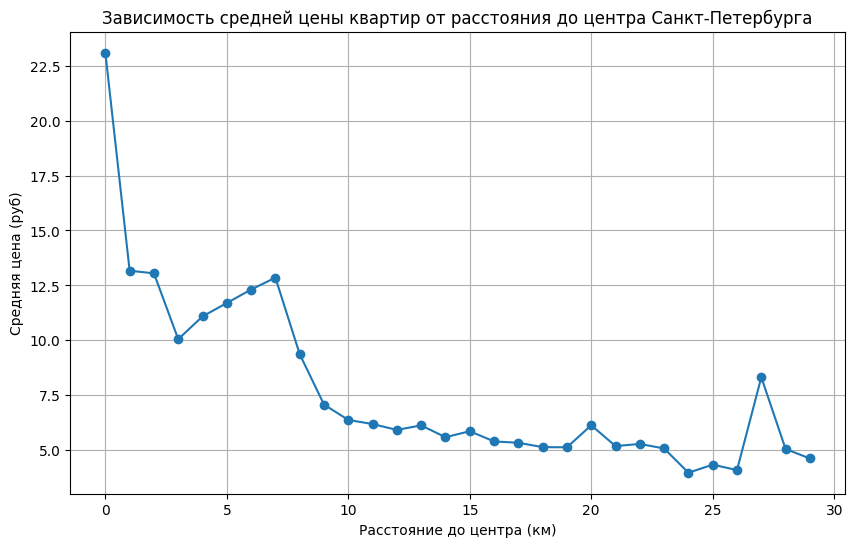

In [72]:
# Построим график с визуализацией полученного результата

plt.figure(figsize=(10, 6))
plt.plot(price_by_distance.index, price_by_distance['last_price'], marker='o')

# Отключаем научную нотацию для оси Y

ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(useOffset=False, style='plain')

plt.title('Зависимость средней цены квартир от расстояния до центра Санкт-Петербурга')
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Средняя цена (руб)')
plt.grid(True)
plt.show()

Основные выводы:

1.	Резкое снижение цены на квартиры по мере увеличения расстояния от центра:
- На начальных значениях (0-5 км) цены значительно выше, что соответствует высокому спросу на недвижимость в центральной части города.
- Примерно с расстояния 5 км наблюдается сильное падение средней цены.
2.	Стабилизация после 10 км:
- После 10 км от центра наблюдается стабилизация цен, хотя они продолжают незначительно колебаться, находясь на более низком уровне по сравнению с центральными районами.

3.	Аномальный рост после 25 км:
- На расстоянии примерно 25-30 км от центра наблюдается резкий скачок цен, что может быть связано с уникальными факторами в этой зоне — например, наличие престижных пригородных районов или элитной недвижимости.

### Общий вывод / General conclusion

🔹 **General conclusion Side note**

The project analyzed Yandex Real Estate archive data to identify price drivers for apartments in St. Petersburg and surroundings.

Preprocessing: handled missing values, duplicates, outliers; engineered key features (sqm price, posting date splits, distance to center).

Main drivers: total area (strongest), living area, kitchen area, floor type (first/last cheaper), year of posting (captures market cycles).

By locality: St. Petersburg and prestige suburbs (Repino, Zelenogorsk, Pushkin) show highest sqm prices; remote villages lowest due to weak demand/infrastructure.

By distance: steep central premium within 3–5 km; stabilization after ~10 km; anomalies beyond 20–25 km from elite suburban pockets.

Overall, size, location, and centrality dominate pricing, with clear stratification between central/prestige zones and remote low-demand areas.

---


Целью проекта было изучение архивных данных объявлений сервиса Яндекс Недвижимость для определения факторов, влияющих на рыночную стоимость квартир в Санкт-Петербурге и окрестностях. Было проведено исследование, включающее обработку данных, поиск аномалий, расчет новых параметров и анализ ключевых факторов, влияющих на стоимость объектов.

**Предобработка данных**

В ходе работы были выявлены и устранены пропуски в данных, исправлены неявные дубликаты и выбивающиеся значения. Некоторые пропущенные значения, такие как количество балконов или высота потолков, были заполнены наиболее логичными значениями (например, 0 балконов, медианная высота потолков). Также был добавлен ряд новых признаков: цена за квадратный метр, день, месяц и год публикации объявления, расстояние до центра города в километрах.

Основные параметры, влияющие на стоимость
Наибольшее влияние на цену объекта недвижимости оказали следующие параметры:

- Общая площадь — сильная положительная корреляция, логично предположить, что квартиры большего размера стоят дороже.
- Жилая площадь — также существенная положительная корреляция, особенно для больших квартир.
- Площадь кухни — меньший, но всё же значимый фактор.
- Тип этажа — объекты на первом и последних этажах дешевле.
- Дата размещения — небольшие различия в цене в зависимости от года, что может свидетельствовать о колебаниях на рынке недвижимости. При этом связь с месяцем или днем недели оказалась незначительной.

**Средняя цена в разных населенных пунктах**

Санкт-Петербург остаётся на вершине по средней стоимости квадратного метра, за ним следуют такие города, как Поселок Репино, Зеленогорск и Пушкин, что связано с престижностью, развитой инфраструктурой и близостью к мегаполису. Самая низкая стоимость квадратного метра наблюдается в Поселке Совхозный, Поселке Ефимовском, Деревне Малой Романовке и других отдаленных населённых пунктах, где инфраструктура менее развита, а спрос на недвижимость ниже.

**Влияние расстояния до центра**

Цена недвижимости резко падает по мере удаления от центра Санкт-Петербурга. На графике отчетливо видно, что наибольшая стоимость зафиксирована в радиусе до 3 км от центра, далее цена стабилизируется на уровне 4-8 млн рублей за объект, а после 20 км от центра снова наблюдаются резкие изменения. Вблизи центра расположены престижные и элитные объекты, тогда как в пригородах чаще встречаются объекты с более доступными ценами.

**Итог**

Результаты анализа подтверждают, что основными факторами, определяющими цену квартиры, являются площадь, местоположение, этаж и тип этажа. Удалённость от центра города также оказывает значительное влияние, особенно на цены элитной недвижимости. При этом центральные районы и курортные пригороды остаются наиболее дорогостоящими, а отдалённые населённые пункты предлагают более доступные варианты.